# CISC 451/839 Topics in Data Analytics 
## Course Project - Using Feature Engineering and Supervised Learning to Predict Game Results in Professional Hockey 
### Gavin McClelland - 10211444 
### Marshall Cunningham - 20249991

TODO: Fix this description

The objectives of this notebook are as follows: 
- Build on top of the previous approaches included in the midterm submission which featured extensive EDA and simple model construction to justify the validity of the project (not trivial to understand game results if information about the score is omitted)
- Using performance trends from previous games, aim to develop models to predict the result of a game before it happens
    - we are only concerned with the binary classification task of predicting wins and losses, not the condition of victory (such as winning in regulation, overtime, or in a shootout)

## Contents

The analytics process contained in this notebook is as follows:

1. Read-in Data
2. Create features in the range [0,1]
3. Min-Max normalization
4. Feature selection


In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix,roc_curve,auc
%cd "C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data"
%matplotlib inline

C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data


In [28]:
# Importing datasets, from the previous snapshot of work done for the midterm submission, and more sophisticated information from moneypuck.com 
# team_stats = pd.read_csv("teamstats_2017-2018_2018-2019.csv")
team_stats = pd.read_csv('game_teams_stats.csv')
# adv_stats = pd.read_csv("moneypuck_teamstats2017-2018.csv")
# game_stats = pd.read_csv("moneypuck_allgames2017.csv")
game_stats = pd.read_csv("10seasons.csv")

In [29]:
team_stats.drop(team_stats[team_stats.game_id > 2018000000].index, inplace=True)
team_stats = team_stats[['game_id', 'HoA', 'won']]
team_stats.rename(
    columns={
        "game_id": "gameId",
        "HoA": "home_or_away",
        "won": "WON"
    }, inplace=True
)
team_stats['home_or_away'] = team_stats['home_or_away'].str.upper()

In [30]:
game_stats = pd.merge(game_stats, team_stats,how='inner',on=['gameId','home_or_away'])

In [31]:
# Taking the result label from the team stats dataset
game_stats['WON'] = np.where(game_stats['WON'] == True, 1, 0)
game_stats.groupby('WON').count()

,team,season,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame
WON,,,,,,,,,,,,,,,,,,,,,
0,9381,9381,9381,9381,9381,9381,9381,9381,9381,9381,...,9381,9381,9381,9381,9381,9381,9381,9381,9381,9381
1,9361,9361,9361,9361,9361,9361,9361,9361,9361,9361,...,9361,9361,9361,9361,9361,9361,9361,9361,9361,9361


In [32]:
game_stats.drop(columns=['season',
                        'name',
                        'playerTeam',
                        'opposingTeam',
                        'gameDate',
                        'position',
                        'situation',
                        'iceTime',
                        'playoffGame'], inplace=True)                     
game_stats.head()

,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,WON
0,TOR,2010020001,HOME,0.3191,0.4538,0.4342,23.965,1.469,1.480,5.820,...,43,42.078,5,0.562,0.806,0.806,2.891,2.899,2.774,1
1,MTL,2010020001,AWAY,0.6809,0.5462,0.5658,32.814,3.135,2.419,6.379,...,33,33.962,12,0.309,0.000,0.000,1.778,1.772,1.758,0
2,PIT,2010020002,HOME,0.4835,0.5603,0.5698,34.905,3.173,2.536,7.994,...,37,39.188,7,0.389,0.410,0.410,3.369,3.482,3.452,0
3,PHI,2010020002,AWAY,0.5165,0.4397,0.4302,26.012,3.390,1.782,5.868,...,49,46.974,3,0.552,0.318,0.318,3.406,3.287,3.225,1
4,MIN,2010020003,HOME,0.4120,0.4870,0.4805,28.668,2.644,2.152,6.873,...,40,42.408,5,0.428,0.908,0.908,3.292,3.472,3.391,0


In [33]:
# most features have a 'for' and 'against' pair, so we will combine them into a ratio in the range 0:1, which adds additional context to the game (i.e. which team had more shots on goal, etc.)
entries = []
for column in game_stats.columns.tolist():
    if column[-3:] == 'For':
        entries.append(column[:-3])
# NOTE: This took awhile to figure out, but if the stat has '0' in the for AND against columns, then the ratio will be null. If this is the case, we assign a ratio of 0.5 to each team with that gameId which provides a neutral, non-zero weight
for x in entries:
    game_stats[f'{x}Ratio'] = game_stats.apply(lambda row: row[f'{x}For'] / (row[f'{x}For'] + row[f'{x}Against']) if (row[f'{x}For'] + row[f'{x}Against']) != 0 else 0.5, axis=1)
    game_stats.drop(columns=[f'{x}For',f'{x}Against'],inplace=True)
game_stats.drop(columns=['goalsRatio'],inplace=True) # Dropping goalsRatio as it is nearly directly responsible for game outcome with the exception of ties

In [34]:
# note that many of the probabalistic statistics (such as xGoalsPercentage) are not always a direct indicator of success. Teams with an xGoalsPercentage less than 50% still win games (roughly 20%)
game_stats.loc[(game_stats.xGoalsPercentage < 0.5) & (game_stats.WON == 1)].shape[0]

3463

In [35]:
cols_to_normalize = game_stats.drop(columns=['team','gameId','home_or_away','WON']).columns.tolist()
# Min-Max Normalization
for column in cols_to_normalize:
        game_stats[column] = (game_stats[column] - game_stats[column].min()) / (game_stats[column].max() - game_stats[column].min())
game_stats

,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,WON,xOnGoalRatio,xGoalsRatio,xReboundsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,TOR,2010020001,HOME,0.282520,0.421026,0.384073,1,0.363208,0.282488,0.310877,...,0.433891,0.384085,0.409142,0.705882,0.268453,0.000000,0.000000,0.342626,0.340433,0.351453
1,MTL,2010020001,AWAY,0.717480,0.578974,0.615927,0,0.636792,0.717512,0.689123,...,0.566109,0.615915,0.590858,0.294118,0.731547,1.000000,1.000000,0.657374,0.659567,0.648547
2,PIT,2010020002,HOME,0.480164,0.603077,0.622974,0,0.628134,0.480125,0.637126,...,0.558438,0.622924,0.576924,0.300000,0.638081,0.436813,0.436813,0.503605,0.480948,0.477473
3,PHI,2010020002,AWAY,0.519836,0.396923,0.377026,1,0.371866,0.519875,0.362874,...,0.441562,0.377076,0.423076,0.700000,0.361919,0.563187,0.563187,0.496395,0.519052,0.522527
4,MIN,2010020003,HOME,0.394205,0.477778,0.465645,0,0.470044,0.394244,0.537067,...,0.437429,0.465677,0.429371,0.500000,0.549767,0.190731,0.190731,0.459902,0.432858,0.433567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18737,VAN,2017021269,AWAY,0.526809,0.525470,0.525722,0,0.534239,0.526764,0.470607,...,0.547047,0.525659,0.544862,0.529412,0.489789,0.470156,0.470156,0.533316,0.556175,0.564338
18738,DAL,2017021270,AWAY,0.574657,0.221026,0.238196,1,0.246140,0.574682,0.356214,...,0.310713,0.238095,0.334534,0.461538,0.363252,0.777622,0.777622,0.441858,0.504536,0.496929
18739,L.A,2017021270,HOME,0.425343,0.778974,0.761804,0,0.753860,0.425318,0.643786,...,0.689287,0.761905,0.665466,0.538462,0.636748,0.222378,0.222378,0.558142,0.495464,0.503071
18740,MIN,2017021271,AWAY,0.577783,0.397436,0.323820,1,0.352376,0.577728,0.386562,...,0.465282,0.323810,0.392685,0.888889,0.371621,0.000000,0.000000,0.578462,0.621175,0.622651


In [36]:
# rearranging columns to beginning of df for organization purposes
cols = game_stats.drop(columns=['WON']).columns.tolist()
cols = ['WON'] + cols
game_stats = game_stats.reindex(columns=cols)
game_stats.head()

,WON,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalRatio,xGoalsRatio,xReboundsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,1,TOR,2010020001,HOME,0.282520,0.421026,0.384073,0.363208,0.282488,0.310877,...,0.433891,0.384085,0.409142,0.705882,0.268453,0.000000,0.000000,0.342626,0.340433,0.351453
1,0,MTL,2010020001,AWAY,0.717480,0.578974,0.615927,0.636792,0.717512,0.689123,...,0.566109,0.615915,0.590858,0.294118,0.731547,1.000000,1.000000,0.657374,0.659567,0.648547
2,0,PIT,2010020002,HOME,0.480164,0.603077,0.622974,0.628134,0.480125,0.637126,...,0.558438,0.622924,0.576924,0.300000,0.638081,0.436813,0.436813,0.503605,0.480948,0.477473
3,1,PHI,2010020002,AWAY,0.519836,0.396923,0.377026,0.371866,0.519875,0.362874,...,0.441562,0.377076,0.423076,0.700000,0.361919,0.563187,0.563187,0.496395,0.519052,0.522527
4,0,MIN,2010020003,HOME,0.394205,0.477778,0.465645,0.470044,0.394244,0.537067,...,0.437429,0.465677,0.429371,0.500000,0.549767,0.190731,0.190731,0.459902,0.432858,0.433567


In [37]:
window_lengths = (1, 3)
new_cols = ['team','home_or_away','gameId']

for col in game_stats.columns:
    if col in new_cols:
        continue
    if col == 'WON':
        new_cols.append(col)
    for length in window_lengths:
        new_cols.append(f'{col}Prev{length}')
new_df = pd.DataFrame(columns=new_cols)
for team in game_stats.team.sort_values(ascending=True).unique().tolist():
    # print(team)
    df = game_stats.loc[game_stats['team'] == team]
    # print(df)
    df.sort_values('gameId', ascending=True, inplace=True)
    for col in df.columns:
        if col != 'WON' and col in new_cols:
            continue
        for length in window_lengths:
            df[f'{col}Prev{length}'] = df[col].rolling(length).mean().shift(1)
        if col != 'WON':
            df.drop(col, axis=1, inplace=True)
    new_df = pd.concat([new_df, df])

In [38]:
new_df.dropna(inplace=True)

In [39]:
new_df

,team,home_or_away,gameId,WON,WONPrev1,WONPrev3,xGoalsPercentagePrev1,xGoalsPercentagePrev3,corsiPercentagePrev1,corsiPercentagePrev3,...,xGoalsFromActualReboundsOfShotsRatioPrev1,xGoalsFromActualReboundsOfShotsRatioPrev3,reboundxGoalsRatioPrev1,reboundxGoalsRatioPrev3,totalShotCreditRatioPrev1,totalShotCreditRatioPrev3,scoreAdjustedTotalShotCreditRatioPrev1,scoreAdjustedTotalShotCreditRatioPrev3,scoreFlurryAdjustedTotalShotCreditRatioPrev1,scoreFlurryAdjustedTotalShotCreditRatioPrev3
80,ANA,HOME,2010020041,1,0.0,0.000000,0.061193,0.245492,0.044615,0.235726,...,0.017017,0.125811,0.017017,0.125811,0.064582,0.271394,0.061508,0.269048,0.074276,0.274134
104,ANA,HOME,2010020053,0,1.0,0.333333,0.314980,0.219083,0.409744,0.281140,...,0.371278,0.137914,0.371278,0.137914,0.315991,0.247575,0.292864,0.240552,0.304908,0.250481
132,ANA,HOME,2010020067,1,0.0,0.333333,0.484011,0.286728,0.630940,0.361766,...,0.357728,0.248674,0.357728,0.248674,0.556548,0.312373,0.543680,0.299351,0.533439,0.304207
156,ANA,AWAY,2010020079,0,1.0,0.666667,0.496994,0.431995,0.424957,0.488547,...,0.237500,0.322169,0.237500,0.322169,0.543377,0.471972,0.534213,0.456919,0.533341,0.457229
167,ANA,AWAY,2010020084,1,0.0,0.333333,0.407550,0.462852,0.737949,0.597949,...,1.000000,0.531743,1.000000,0.531743,0.437430,0.512452,0.446709,0.508201,0.441124,0.502635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18602,WSH,HOME,2017021202,0,1.0,1.000000,0.436283,0.533141,0.493162,0.475613,...,0.178841,0.316610,0.178841,0.316610,0.465415,0.557463,0.444270,0.576708,0.444505,0.583738
18641,WSH,AWAY,2017021221,1,0.0,0.666667,0.390478,0.411557,0.475043,0.450199,...,0.222683,0.174943,0.222683,0.174943,0.427664,0.447045,0.395881,0.447792,0.392139,0.451791
18651,WSH,AWAY,2017021226,1,1.0,0.666667,0.526208,0.450990,0.485299,0.484501,...,0.371566,0.257697,0.371566,0.257697,0.574764,0.489281,0.599872,0.480008,0.602960,0.479868
18686,WSH,HOME,2017021244,0,1.0,0.666667,0.529574,0.482087,0.369060,0.443134,...,0.252366,0.282205,0.252366,0.282205,0.535866,0.512765,0.575121,0.523624,0.601835,0.532311


### Feature Selection
We already have quite a few features (106), so before looking at previous games to predict the result of a game before it happens, let's find out which of these features are of any significance

In [40]:
gs_cpy = game_stats
new_df.columns.tolist()

['team',
 'home_or_away',
 'gameId',
 'WON',
 'WONPrev1',
 'WONPrev3',
 'xGoalsPercentagePrev1',
 'xGoalsPercentagePrev3',
 'corsiPercentagePrev1',
 'corsiPercentagePrev3',
 'fenwickPercentagePrev1',
 'fenwickPercentagePrev3',
 'xOnGoalRatioPrev1',
 'xOnGoalRatioPrev3',
 'xGoalsRatioPrev1',
 'xGoalsRatioPrev3',
 'xReboundsRatioPrev1',
 'xReboundsRatioPrev3',
 'xFreezeRatioPrev1',
 'xFreezeRatioPrev3',
 'xPlayStoppedRatioPrev1',
 'xPlayStoppedRatioPrev3',
 'xPlayContinuedInZoneRatioPrev1',
 'xPlayContinuedInZoneRatioPrev3',
 'xPlayContinuedOutsideZoneRatioPrev1',
 'xPlayContinuedOutsideZoneRatioPrev3',
 'flurryAdjustedxGoalsRatioPrev1',
 'flurryAdjustedxGoalsRatioPrev3',
 'scoreVenueAdjustedxGoalsRatioPrev1',
 'scoreVenueAdjustedxGoalsRatioPrev3',
 'flurryScoreVenueAdjustedxGoalsRatioPrev1',
 'flurryScoreVenueAdjustedxGoalsRatioPrev3',
 'shotsOnGoalRatioPrev1',
 'shotsOnGoalRatioPrev3',
 'missedShotsRatioPrev1',
 'missedShotsRatioPrev3',
 'blockedShotAttemptsRatioPrev1',
 'blockedShotAt

Fitting a simple logistic regression model to our features to resolve feature "importances"

In [41]:
# Dropping categorical features
X = new_df.drop(columns=['team','gameId','home_or_away','WON'])
new_df['WON'] = new_df['WON'].astype('int')
Y = new_df['WON']

In [42]:
lr = LogisticRegression()
lr.fit(X,Y)

LogisticRegression()

In [43]:
np.abs(lr.coef_[0])

array([6.63729548e-02, 1.30719402e-02, 6.34641887e-02, 6.25974335e-03,
       2.27921678e-01, 1.05202815e-01, 3.06710181e-02, 8.28319369e-02,
       7.60191919e-02, 2.81015086e-01, 6.37730103e-02, 7.07492142e-03,
       1.31246772e-01, 3.26225129e-01, 2.76223882e-01, 3.89159461e-01,
       2.77775809e-01, 5.84042903e-01, 2.41771218e-01, 3.90624488e-02,
       3.46333538e-01, 4.27605130e-01, 2.03034823e-01, 2.51283654e-01,
       1.06463192e-01, 2.50804589e-01, 2.67570149e-01, 5.03766761e-01,
       3.71161224e-01, 4.40938698e-01, 4.50415332e-01, 4.28923324e-01,
       2.73146426e-01, 1.81872541e-01, 2.29551605e-01, 1.04165467e-01,
       2.03229596e-03, 3.46106948e-01, 7.11620457e-02, 1.53271627e-01,
       1.22888935e-01, 1.99488359e-02, 3.79795713e-02, 4.58755943e-02,
       2.79582636e-01, 4.16699259e-01, 5.28093745e-02, 1.27035027e-01,
       2.78047802e-01, 5.81520267e-01, 2.31441310e-01, 1.38969942e-02,
       1.73664391e-01, 1.23398466e-01, 8.04991951e-03, 1.23091304e-01,
      

Below, we plot our feature coefficients in descending order to observe where a drop-off occurs

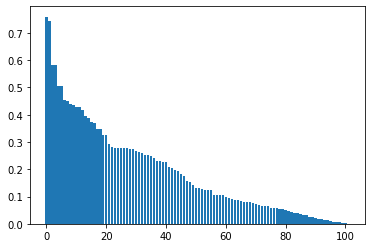

In [44]:
importance = np.abs(lr.coef_[0])
sorted_importance = -np.sort(-importance)
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(sorted_importance))], sorted_importance)
plt.show()

From the plot above, we are choosing the top 10 features as there is an observable drop-off in performance afterwards

Next, we find our columns to drop from our dataset, so we are left with our 10 most important features

In [45]:
cols_to_drop = []
thresh = sorted_importance[10]
print(f'Threshold: {thresh}')
for n,val in enumerate(importance):
    if val < thresh:
        print(val)
        cols_to_drop.append(new_df.columns[n+4])
new_df.drop(cols_to_drop,axis=1,inplace=True)

Threshold: 0.4289233239678895
0.06637295475106605
0.01307194020859164
0.0634641887016224
0.006259743353436932
0.22792167803386326
0.10520281515698911
0.030671018059334552
0.08283193686610846
0.07601919191841967
0.2810150860586244
0.0637730103160614
0.007074921419478348
0.13124677225384326
0.3262251291452242
0.276223882310551
0.389159460628828
0.27777580865740187
0.2417712181810182
0.039062448822769734
0.3463335376783414
0.4276051298736373
0.2030348234309753
0.2512836537864747
0.1064631915885918
0.2508045894557712
0.26757014854234756
0.37116122408838925
0.27314642585179244
0.18187254079210233
0.2295516053644778
0.10416546729936375
0.0020322959628834977
0.34610694838435446
0.07116204573324614
0.15327162674079126
0.12288893544024297
0.019948835900181424
0.03797957128099608
0.045875594298001664
0.2795826359529659
0.41669925878913544
0.052809374502558064
0.12703502707478742
0.27804780207297086
0.2314413096266199
0.013896994163307252
0.17366439105339868
0.1233984661143326
0.00804991950902627

In [46]:
# Verifying that feature selection worked as expected
print(cols_to_drop)

['WONPrev1', 'WONPrev3', 'xGoalsPercentagePrev1', 'xGoalsPercentagePrev3', 'corsiPercentagePrev1', 'corsiPercentagePrev3', 'fenwickPercentagePrev1', 'fenwickPercentagePrev3', 'xOnGoalRatioPrev1', 'xOnGoalRatioPrev3', 'xGoalsRatioPrev1', 'xGoalsRatioPrev3', 'xReboundsRatioPrev1', 'xReboundsRatioPrev3', 'xFreezeRatioPrev1', 'xFreezeRatioPrev3', 'xPlayStoppedRatioPrev1', 'xPlayContinuedInZoneRatioPrev1', 'xPlayContinuedInZoneRatioPrev3', 'xPlayContinuedOutsideZoneRatioPrev1', 'xPlayContinuedOutsideZoneRatioPrev3', 'flurryAdjustedxGoalsRatioPrev1', 'flurryAdjustedxGoalsRatioPrev3', 'scoreVenueAdjustedxGoalsRatioPrev1', 'scoreVenueAdjustedxGoalsRatioPrev3', 'flurryScoreVenueAdjustedxGoalsRatioPrev1', 'shotsOnGoalRatioPrev1', 'blockedShotAttemptsRatioPrev1', 'blockedShotAttemptsRatioPrev3', 'shotAttemptsRatioPrev1', 'shotAttemptsRatioPrev3', 'reboundsRatioPrev1', 'reboundsRatioPrev3', 'reboundGoalsRatioPrev1', 'reboundGoalsRatioPrev3', 'freezeRatioPrev1', 'freezeRatioPrev3', 'playStoppedRati

Next, we create a correlation heatmap to visualize any redundant/synonymous features, along with those that are too highly correlated with the outcome label 'WON'

In [47]:
new_df.drop(columns=['team','gameId','home_or_away'])

,WON,xPlayStoppedRatioPrev3,flurryScoreVenueAdjustedxGoalsRatioPrev3,shotsOnGoalRatioPrev3,missedShotsRatioPrev1,missedShotsRatioPrev3,savedShotsOnGoalRatioPrev3,lowDangerxGoalsRatioPrev1,mediumDangerxGoalsRatioPrev3,scoreAdjustedShotsAttemptsRatioPrev3,scoreAdjustedUnblockedShotAttemptsRatioPrev3,xGoalsFromxReboundsOfShotsRatioPrev3
80,1,0.190301,0.250507,0.194957,0.263158,0.374386,0.251435,0.071218,0.203230,0.203612,0.214368,0.226564
104,0,0.221398,0.222266,0.265152,0.366667,0.309942,0.295601,0.388113,0.190536,0.252712,0.227055,0.280684
132,1,0.328528,0.278819,0.336058,0.657895,0.429240,0.354235,0.672871,0.365102,0.332797,0.328588,0.401264
156,0,0.472890,0.420221,0.490958,0.428571,0.484378,0.484198,0.435735,0.480307,0.470185,0.473618,0.537380
167,1,0.568505,0.454632,0.572210,0.625000,0.570489,0.576317,0.499545,0.505580,0.595514,0.585537,0.625248
...,...,...,...,...,...,...,...,...,...,...,...,...
18602,0,0.490270,0.560624,0.547801,0.500000,0.393939,0.528103,0.476895,0.485418,0.531052,0.526589,0.425854
18641,1,0.464961,0.422082,0.446745,0.640000,0.455758,0.452095,0.428973,0.567791,0.461958,0.459322,0.400851
18651,1,0.495972,0.445901,0.421012,0.611111,0.583704,0.428832,0.566231,0.574111,0.481264,0.481188,0.404650
18686,0,0.470739,0.500847,0.429193,0.379310,0.543474,0.432473,0.368136,0.543123,0.461601,0.490545,0.419169


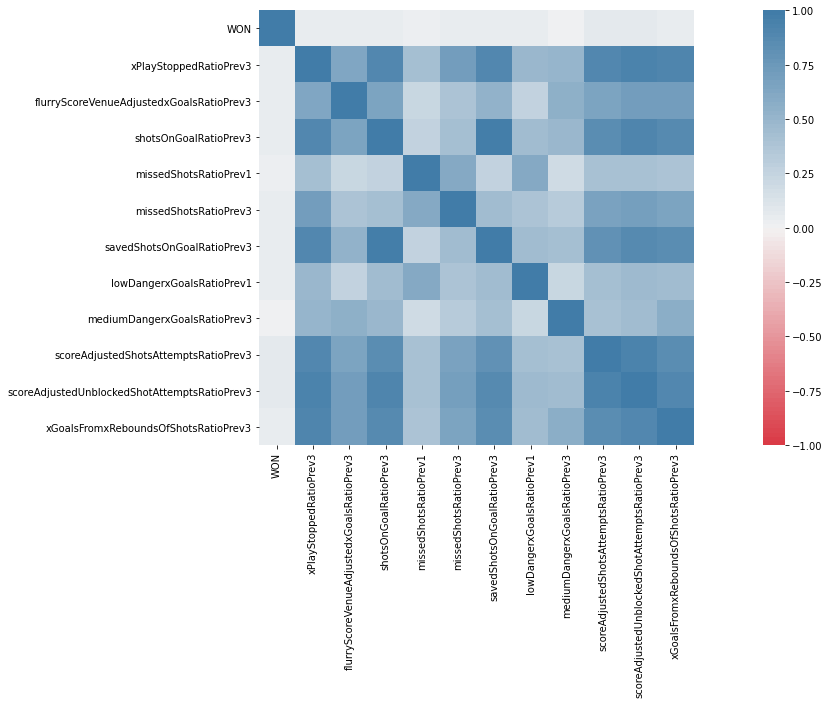

In [48]:
corr = new_df.drop(columns=['team','gameId','home_or_away']).corr()
fig, ax = plt.subplots(figsize=(25,8)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1,
    square=True,
    cmap=sns.diverging_palette(10,240,n=100),
    ax=ax
)

The only duplicate features are different versions of the same stat, which can be seen near the bottom (different versions of shotCredit)
- So, we keep the score & flurry adjusted stat as flurry is more repeatable and regarded as having more predictive power (see report)

In [49]:
# dimensions of the dataset after selecting features
new_df.shape

(18646, 15)

In [50]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
feat = new_df.drop(columns=['team','home_or_away','gameId','WON'])
label = new_df['WON']
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, feat, label, cv=10)
scores

array([0.54959786, 0.53672922, 0.49758713, 0.53297587, 0.53619303,
       0.53297587, 0.50536481, 0.5638412 , 0.49248927, 0.50697425])

In [51]:
x_train,x_test,y_train,y_test = train_test_split(feat,label,test_size=0.2) # test on 20% of dataset 
lr2 = LogisticRegression()
lr2.fit(x_train,y_train)
pred = lr2.predict(x_test)
accuracy_score(y_test,pred)

0.5257372654155495

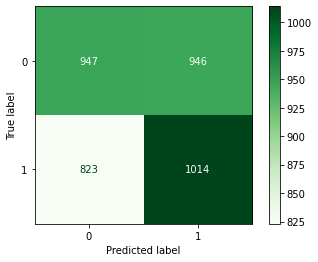

In [52]:
plot_confusion_matrix(lr2,x_test,y_test,cmap=plt.cm.Greens)

In [27]:
new_df.head()

,team,home_or_away,gameId,WON,WONPrev1,WONPrev3,shotsOnGoalRatioPrev3,shotAttemptsRatioPrev1,savedShotsOnGoalRatioPrev3,savedUnblockedShotAttemptsRatioPrev3,scoreAdjustedShotsAttemptsRatioPrev1,scoreAdjustedShotsAttemptsRatioPrev3,scoreAdjustedUnblockedShotAttemptsRatioPrev1,xGoalsFromxReboundsOfShotsRatioPrev3,totalShotCreditRatioPrev3
33203,ANA,AWAY,2010020009,0,0.0,0.0,0.250116,0.454545,0.271138,0.311858,0.412936,0.249912,0.474352,0.298313,0.327778
33204,ANA,AWAY,2010020009,0,0.0,0.0,0.283449,0.071429,0.304472,0.342161,0.071429,0.273722,0.090909,0.320685,0.393964
33205,ANA,AWAY,2010020020,0,0.0,0.0,0.507407,0.666667,0.521138,0.371573,0.666667,0.383677,0.500000,0.446409,0.419891
33206,ANA,AWAY,2010020020,0,0.0,0.0,0.509524,0.444444,0.509524,0.321970,0.444444,0.394180,0.375000,0.435222,0.306494
33207,ANA,AWAY,2010020020,0,0.0,0.0,0.619601,0.435115,0.624339,0.430281,0.429608,0.513573,0.403048,0.550374,0.372174
